Epoch [1/5], Loss: 12.8065
Epoch [2/5], Loss: 10.2681
Epoch [3/5], Loss: 8.9391
Epoch [4/5], Loss: 8.9267
Epoch [5/5], Loss: 8.5033
Epoch [6/5], Loss: 8.5026
Epoch [7/5], Loss: 8.2373
Epoch [8/5], Loss: 8.3703
Epoch [9/5], Loss: 8.1930
Epoch [10/5], Loss: 7.9639
Epoch [11/5], Loss: 8.1164
Epoch [12/5], Loss: 8.0319
Epoch [13/5], Loss: 7.7937
Epoch [14/5], Loss: 7.9535
Epoch [15/5], Loss: 7.8277
Epoch [16/5], Loss: 8.0252
Epoch [17/5], Loss: 7.4670
Epoch [18/5], Loss: 7.6632
Epoch [19/5], Loss: 7.2479
Epoch [20/5], Loss: 7.9525
Epoch [21/5], Loss: 7.6092
Epoch [22/5], Loss: 7.3954
Epoch [23/5], Loss: 7.3070
Epoch [24/5], Loss: 7.2813
Epoch [25/5], Loss: 7.5679
Epoch [26/5], Loss: 7.3672
Epoch [27/5], Loss: 7.2799
Epoch [28/5], Loss: 7.6564
Epoch [29/5], Loss: 7.5743
Epoch [30/5], Loss: 7.2893
Epoch [31/5], Loss: 7.4436
Epoch [32/5], Loss: 7.7018
Epoch [33/5], Loss: 6.9712
Epoch [34/5], Loss: 7.4293
Epoch [35/5], Loss: 7.1954
Epoch [36/5], Loss: 7.3051
Epoch [37/5], Loss: 7.2474
Epoch [3

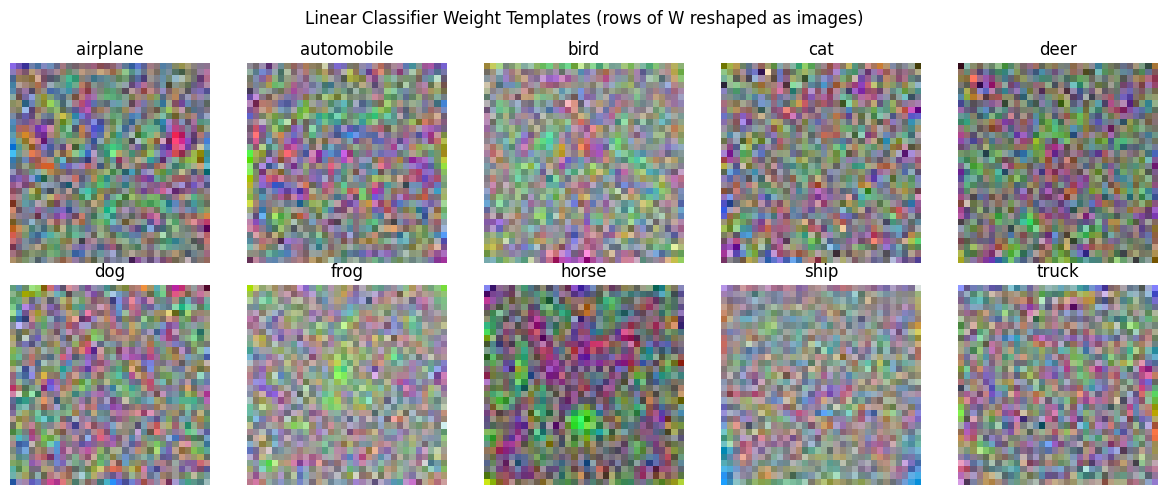

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# ----------------------------
# 1. Load CIFAR-10 dataset
# ----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),  # converts to [0,1] tensor
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

classes = trainset.classes  # ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# ----------------------------
# 2. Define Linear Classifier
# ----------------------------
class LinearClassifier(nn.Module):
    def __init__(self, input_dim=32*32*3, num_classes=10):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten image
        return self.fc(x)

model = LinearClassifier()
device = 'cuda' 
model = model.to(device)

# ----------------------------
# 3. Training loop (very simple)
# ----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(1000):  # train just a few epochs for demo
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/5], Loss: {running_loss/len(trainloader):.4f}")

print("Training complete ✅")

# ----------------------------
# 4. Visualize weight templates
# ----------------------------
W = model.fc.weight.data.cpu()  # shape: (num_classes, 3072)
num_classes = W.shape[0]

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(num_classes):
    W_img = W[i].reshape(3, 32, 32).permute(1, 2, 0)  # to HWC format
    # normalize to [0,1] for visualization
    W_img_norm = (W_img - W_img.min()) / (W_img.max() - W_img.min())
    axes[i].imshow(W_img_norm)
    axes[i].set_title(classes[i])
    axes[i].axis('off')

plt.suptitle("Linear Classifier Weight Templates (rows of W reshaped as images)")
plt.tight_layout()
plt.show()



Training model WITHOUT regularization...
Epoch [1/5] Loss: 2.0255
Epoch [2/5] Loss: 1.9043
Epoch [3/5] Loss: 1.8874
Epoch [4/5] Loss: 1.8664
Epoch [5/5] Loss: 1.8761

Training model WITH regularization (weight decay=1e-3)...
Epoch [1/5] Loss: 2.0272
Epoch [2/5] Loss: 1.9270
Epoch [3/5] Loss: 1.8560
Epoch [4/5] Loss: 1.8807
Epoch [5/5] Loss: 1.8721


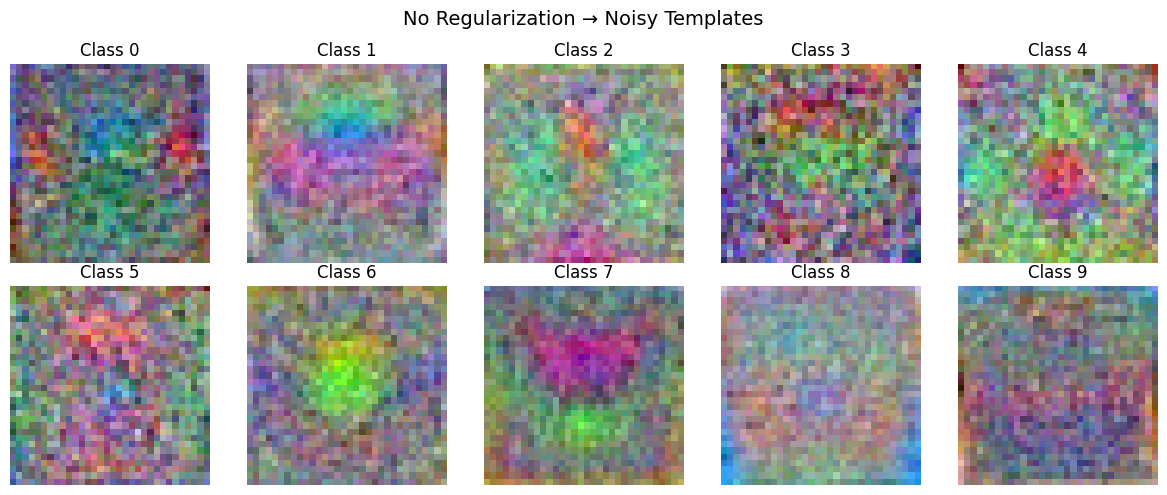

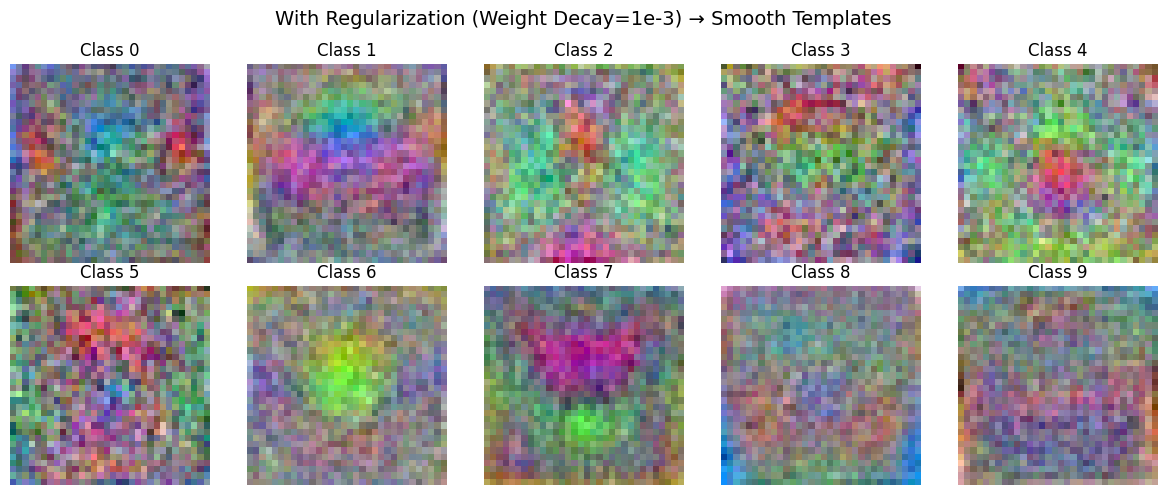

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# 1. Load CIFAR-10 dataset
# ----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

# ----------------------------
# 2. Define a simple linear classifier
# ----------------------------
class LinearClassifier(nn.Module):
    def __init__(self, input_dim=32*32*3, num_classes=10):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ----------------------------
# 3. Training function
# ----------------------------
def train_model(weight_decay, epochs=10):
    model = LinearClassifier().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(trainloader):.4f}")
    return model

# ----------------------------
# 4. Train two models:
#    (a) No regularization
#    (b) With regularization (weight decay)
# ----------------------------
print("\nTraining model WITHOUT regularization...")
model_no_reg = train_model(weight_decay=0.0, epochs=5)

print("\nTraining model WITH regularization (weight decay=1e-3)...")
model_reg = train_model(weight_decay=1e-3, epochs=5)

# ----------------------------
# 5. Visualize class templates (rows of W reshaped into images)
# ----------------------------
def visualize_templates(model, title):
    W = model.fc.weight.detach().cpu().numpy()  # shape: (num_classes, 3072)
    num_classes = W.shape[0]
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()

    for i in range(num_classes):
        W_img = W[i].reshape(3, 32, 32).transpose(1, 2, 0)
        # Normalize to 0–1 for visualization
        W_img = (W_img - W_img.min()) / (W_img.max() - W_img.min())
        axes[i].imshow(W_img)
        axes[i].set_title(f"Class {i}")
        axes[i].axis("off")
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_templates(model_no_reg, "No Regularization → Noisy Templates")
visualize_templates(model_reg, "With Regularization (Weight Decay=1e-3) → Smooth Templates")
